In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/RecYards/recyards_wr_backtest_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

10252


### Split data into train/test/validation

In [5]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

10252


In [6]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [7]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

#features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag','PositionId']
features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag']

all_features = features + [target_variable]

In [24]:
train_test_data = raw_data.copy()
train_test_data = train_test_data.dropna()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [25]:
X.shape

(8841, 539)

### Use random search to narrow down hyperparameter grid

In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define parameter grid for RandomizedSearchCV for linear booster
param_dist_linear = {
    'n_estimators': randint(50, 500),                # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),             # Lower learning rate for linear models
    'reg_alpha': uniform(0, 1),                      # L1 regularization
    'reg_lambda': uniform(0.001, 10)                 # L2 regularization
}

# Create XGBoost regressor with linear booster
xgb_linear = XGBRegressor(booster='gblinear', random_state=42)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with linear booster
xgb_random_linear = RandomizedSearchCV(
    estimator=xgb_linear, 
    param_distributions=param_dist_linear, 
    n_iter=100,                   # Fewer iterations for a linear model
    cv=kfolds, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model on the training data
xgb_random_linear.fit(X_train, y_train)

# Display best parameters and scores
print("Best Parameters (Linear Booster):", xgb_random_linear.best_params_)
print("Best Score (R-squared):", xgb_random_linear.best_score_)

# Evaluate on the test set
best_xgb_linear = xgb_random_linear.best_estimator_

y_pred_test_linear = best_xgb_linear.predict(X_test)
test_r2_score_linear = best_xgb_linear.score(X_test, y_test)
test_rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_test_linear))
test_mae_linear = mean_absolute_error(y_test, y_pred_test_linear)

print("Test R-squared (Linear Booster):", test_r2_score_linear)
print(f'Test RMSE (Linear Booster): {test_rmse_linear:.4f}')
print(f'Test MAE (Linear Booster): {test_mae_linear:.4f}')

# Create and display output DataFrame
output_df_linear = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test_linear})
output_df_linear['residuals'] = output_df_linear[target_variable] - output_df_linear['pred_' + target_variable]
output_df_linear.sort_values('residuals', ascending=False).head()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters (Linear Booster): {'learning_rate': 0.025071754396542946, 'n_estimators': 236, 'reg_alpha': 0.18651851039985423, 'reg_lambda': 0.40875141554763916}
Best Score (R-squared): 0.24334937934982745
Test R-squared (Linear Booster): 0.25364374606358786
Test RMSE (Linear Booster): 33.2844
Test MAE (Linear Booster): 25.2372


,TargetRecYards,pred_TargetRecYards,residuals
9818,215.0,69.789223,145.210777
6570,158.0,23.478737,134.521263
4525,201.0,70.254776,130.745224
8966,199.0,69.357445,129.642555
9418,157.0,30.392694,126.607306


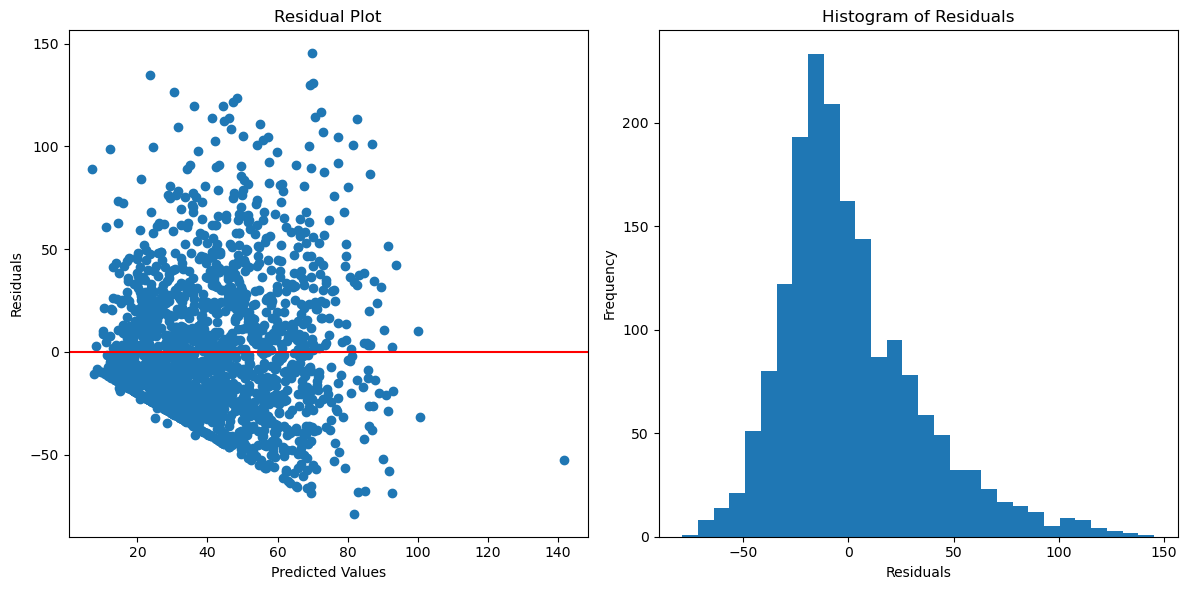

In [27]:
# Calculate residuals
residuals = y_test - y_pred_test_linear

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test_linear, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

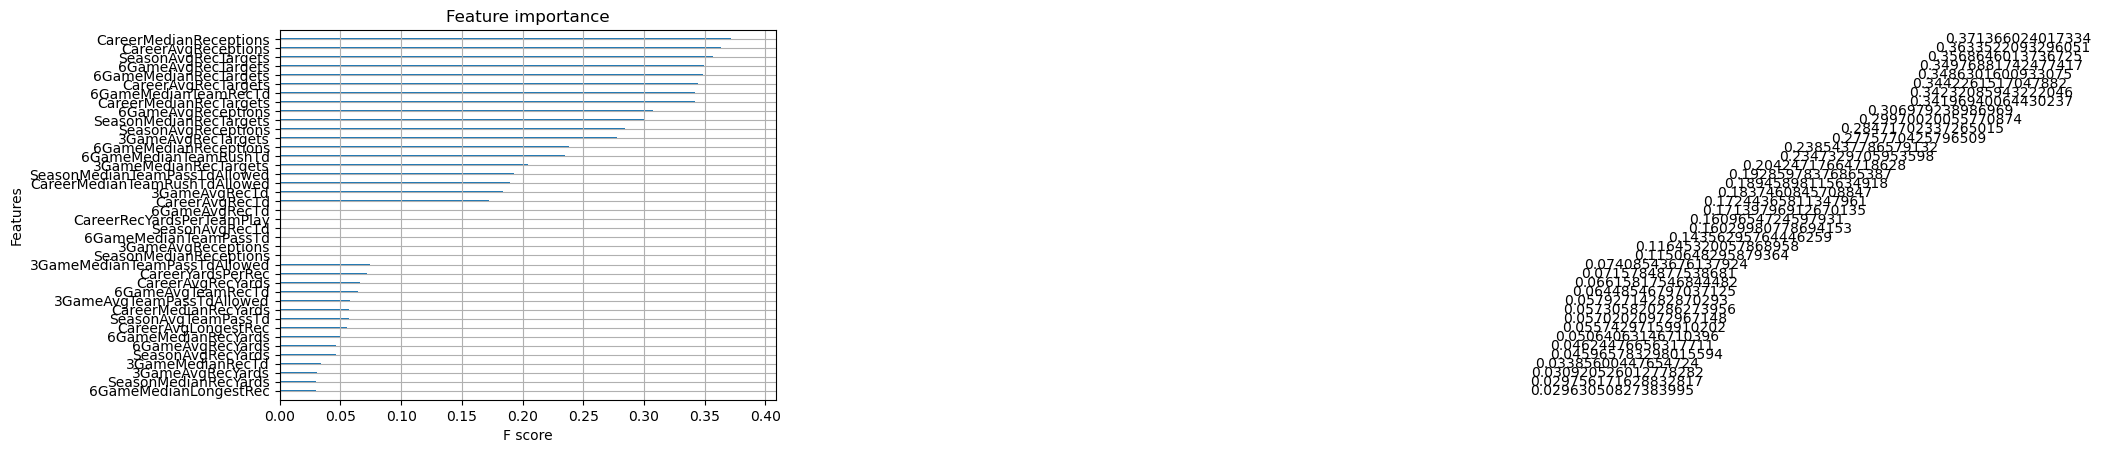

<Figure size 1800x1200 with 0 Axes>

In [29]:
# Plot feature importance
xgboost.plot_importance(best_xgb_linear, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

In [31]:
train_test_data['x{}'.format(variable)] = best_xgb_linear.predict(train_test_data[features])
train_test_data['Residual'] = train_test_data[target_variable] - train_test_data['x{}'.format(variable)]
train_test_data['AbsResidual'] = [np.abs(i) for i in train_test_data['Residual']]

train_test_data.sort_values('AbsResidual', ascending=False)[['GameDate','Player',target_variable,'x{}'.format(variable),'AbsResidual']].head(20)

,GameDate,Player,TargetRecYards,xRecYards,AbsResidual
4534,2022-01-02,Ja'Marr Chase,266.0,59.412697,206.587303
9851,2020-11-29,Tyreek Hill,269.0,72.053513,196.946487
540,2019-10-06,Amari Cooper,226.0,63.739899,162.260101
10033,2019-10-06,Will Fuller,217.0,54.878025,162.121975
4153,2022-01-23,Gabriel Davis,201.0,40.097481,160.902519
530,2018-12-09,Amari Cooper,217.0,61.169544,155.830456
7331,2023-01-01,Mike Evans,207.0,57.438438,149.561562
9818,2018-11-19,Tyreek Hill,215.0,69.789223,145.210777
2126,2019-10-27,Cooper Kupp,220.0,76.826775,143.173225
5339,2018-09-23,Jordy Nelson,173.0,31.126825,141.873175


### Persist the best model in the models dir

In [ ]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_wr_backtest_linear.pkl'.format(variable.lower())
joblib.dump(best_xgb_linear, model_file_path)

In [ ]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_wr_backtest_linear.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")

                                  Feature    Importance
48                 CareerMedianReceptions  1.682790e-01
42                    CareerAvgReceptions  1.646476e-01
58                    SeasonAvgRecTargets  1.617079e-01
20                     6GameAvgRecTargets  1.584925e-01
26                  6GameMedianRecTargets  1.579766e-01
39                    CareerAvgRecTargets  1.559809e-01
216                  6GameMedianTeamRecTd  1.551176e-01
45                 CareerMedianRecTargets  1.549583e-01
23                     6GameAvgReceptions  1.391031e-01
64                 SeasonMedianRecTargets  1.358047e-01
61                    SeasonAvgReceptions  1.290153e-01
1                      3GameAvgRecTargets  1.257799e-01
29                  6GameMedianReceptions  1.080926e-01
176                 6GameMedianTeamRushTd  1.063657e-01
7                   3GameMedianRecTargets  9.255156e-02
423         SeasonMedianTeamPassTdAllowed  8.739153e-02
378         CareerMedianTeamRushTdAllowed  8.585

<Figure size 1000x800 with 0 Axes>

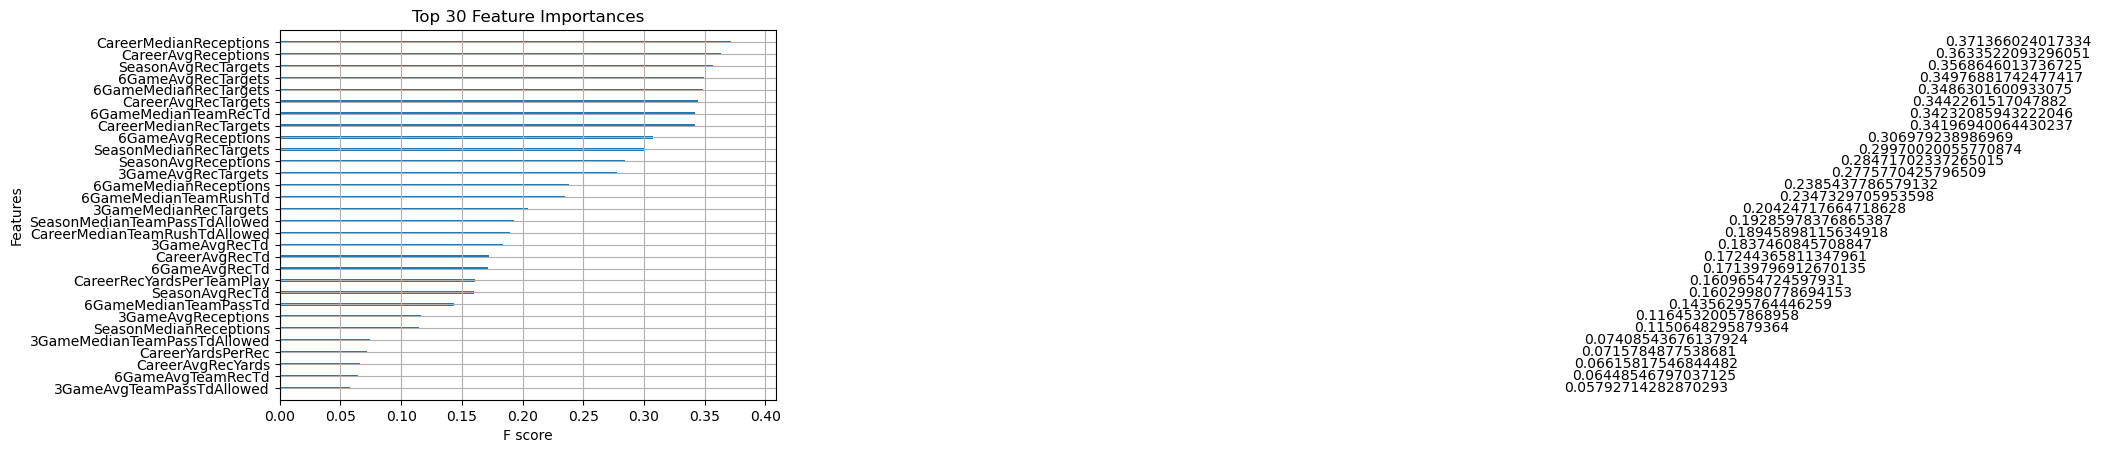

In [33]:
from xgboost import XGBRegressor, plot_importance
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `best_xgb_linear` is your trained model and `X_train` is your original training data

# Step 1: Extract feature importances from the model
feature_importances = best_xgb_linear.feature_importances_

# Step 2: Create a DataFrame to display feature names and their corresponding importance
feature_names = X_train.columns  # Use original feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)

# Step 3: Plot feature importance using XGBoost's built-in plotting function
plt.figure(figsize=(10, 8))
plot_importance(best_xgb_linear, importance_type='weight', max_num_features=30)  # Plot top 30 features by default
plt.title('Top 30 Feature Importances')
plt.show()
